In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

In [2]:
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

def compute_spread(p1, p2, tf, x):
    data1 = get_rates(p1, tf, x)
    data2 = get_rates(p2, tf, x)
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


# Mean Reversion Based

In [12]:
EURUSD = get_rates('EURUSD.a', mt5.TIMEFRAME_H1, 10000)
GBPUSD = get_rates('GBPUSD.a', mt5.TIMEFRAME_H1, 10000)

combined_df = pd.concat([EURUSD['close'].rename('EURUSD_close'),
                         GBPUSD['close'].rename('GBPUSD_close')], axis=1)

## Correlation

<AxesSubplot:xlabel='time'>

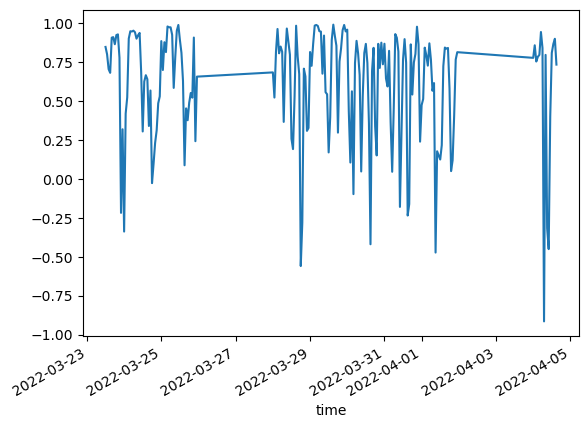

In [13]:
window_size = 5  # Change this to the size of the window you want
combined_df['rolling_corr'] = combined_df['EURUSD_close'].rolling(window=window_size).corr(combined_df['GBPUSD_close'])
combined_df['rolling_corr'].iloc[0:200].plot()

In [14]:
combined_df['EURUSD_return'] = combined_df['EURUSD_close'].pct_change()
combined_df['GBPUSD_return'] = combined_df['GBPUSD_close'].pct_change()
combined_df['diff'] = combined_df['EURUSD_return'] - combined_df['GBPUSD_return']
combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
adf_test(combined_df['rolling_corr_returns'].dropna())

{'ADF Statistic': -35.1225344414207,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.431005015196264,
  '5%': -2.8618294777083033,
  '10%': -2.5669240838467666}}

<AxesSubplot:xlabel='time'>

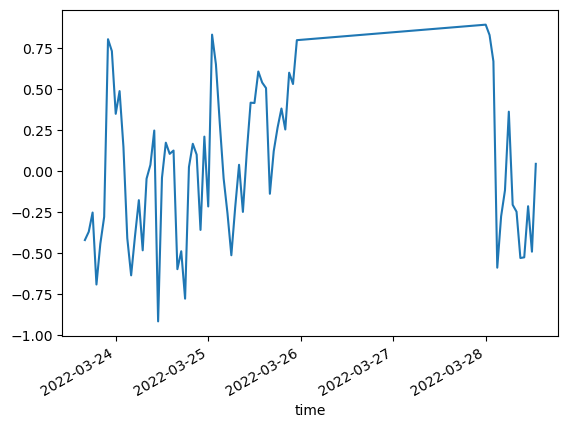

In [15]:
combined_df['rolling_corr_returns'].iloc[8:78].plot()

In [17]:
EU_GU = combined_df

In [39]:
def get_pair_correlations(symbol1, symbol2, window):
    s1 = str(symbol1)
    s2 = str(symbol2)
    symbol1 = get_rates(symbol1, mt5.TIMEFRAME_H4, 5000)
    symbol2 = get_rates(symbol2, mt5.TIMEFRAME_H4, 5000)

    combined_df = pd.concat([symbol1['close'].rename(f'{s1}_close'),
                            symbol2['close'].rename(f'{s2}_close')], axis=1)

    window_size = window  # Change this to the size of the window you want
    combined_df['rolling_corr'] = combined_df[f'{s1}_close'].rolling(window=window_size).corr(combined_df[f'{s2}_close'])
    # combined_df['rolling_corr'].iloc[0:200].plot()
    combined_df[f'{s1}_return'] = combined_df[f'{s1}_close'].pct_change()
    combined_df[f'{s2}_return'] = combined_df[f'{s2}_close'].pct_change()
    combined_df['diff'] = combined_df[f'{s1}_return'] - combined_df[f'{s2}_return']
    combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
    combined_df['shifted_rolling_corr_returns'] = combined_df['rolling_corr_returns'].shift(1)
    # print(adf_test(combined_df['rolling_corr_returns'].dropna()))
    return combined_df.dropna()

In [45]:
EU_GU = get_pair_correlations('EURUSD.a', 'GBPUSD.a', 5)

In [59]:
AU_NU

,AUDUSD.a_close,NZDUSD.a_close,rolling_corr,AUDUSD.a_return,NZDUSD.a_return,diff,rolling_corr_returns,shifted_rolling_corr_returns
time,,,,,,,,
2020-08-17 04:00:00,0.71761,0.65316,-0.567756,-0.002765,0.000031,-0.002796,0.163282,-0.737364
2020-08-17 08:00:00,0.71800,0.65293,-0.564513,0.000543,-0.000352,0.000896,0.173890,0.163282
2020-08-17 12:00:00,0.71949,0.65296,-0.622784,0.002075,0.000046,0.002029,0.095055,0.173890
2020-08-17 16:00:00,0.72115,0.65456,0.766425,0.002307,0.002450,-0.000143,-0.105518,0.095055
2020-08-17 20:00:00,0.72152,0.65576,0.868190,0.000513,0.001833,-0.001320,-0.254039,-0.105518
...,...,...,...,...,...,...,...,...
2023-10-27 04:00:00,0.63439,0.58236,0.950952,0.001437,-0.000086,0.001522,-0.558480,-0.404389
2023-10-27 08:00:00,0.63503,0.58262,0.957796,0.001009,0.000446,0.000562,-0.452368,-0.558480
2023-10-27 12:00:00,0.63505,0.58296,0.890845,0.000031,0.000584,-0.000552,0.474508,-0.452368


<AxesSubplot:xlabel='time'>

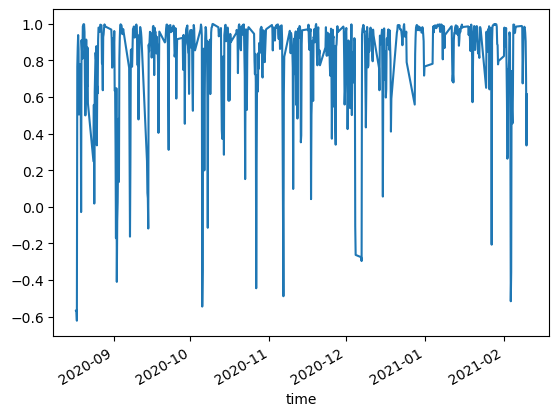

In [61]:
AU_NU = get_pair_correlations('AUDUSD.a', 'NZDUSD.a', 5)
AU_NU['rolling_corr'].iloc[0:750].plot()

In [74]:
AU_NU.corr()

,AUDUSD.a_close,NZDUSD.a_close,rolling_corr,AUDUSD.a_return,NZDUSD.a_return,diff,rolling_corr_returns,shifted_rolling_corr_returns
AUDUSD.a_close,1.000000,0.965848,0.003780,0.030595,0.025639,0.010837,-0.003965,-0.004412
NZDUSD.a_close,0.965848,1.000000,-0.020269,0.027497,0.027517,0.000012,0.010639,0.010365
rolling_corr,0.003780,-0.020269,1.000000,-0.003997,-0.007186,0.006927,-0.006935,0.021117
AUDUSD.a_return,0.030595,0.027497,-0.003997,1.000000,0.894367,0.231720,-0.025514,-0.008409
NZDUSD.a_return,0.025639,0.027517,-0.007186,0.894367,1.000000,-0.227915,0.025736,-0.008155
diff,0.010837,0.000012,0.006927,0.231720,-0.227915,1.000000,-0.111501,-0.000568
rolling_corr_returns,-0.003965,0.010639,-0.006935,-0.025514,0.025736,-0.111501,1.000000,0.598644
shifted_rolling_corr_returns,-0.004412,0.010365,0.021117,-0.008409,-0.008155,-0.000568,0.598644,1.000000


In [75]:
np.cov(AU_NU)

array([[ 0.26115327,  0.16260621,  0.16501692, ...,  0.09746161,
         0.01421638,  0.02092063],
       [ 0.16260621,  0.16480447,  0.17044062, ...,  0.00534735,
         0.0369558 , -0.00433707],
       [ 0.16501692,  0.17044062,  0.1772012 , ..., -0.00332087,
         0.03714966, -0.00650682],
       ...,
       [ 0.09746161,  0.00534735, -0.00332087, ...,  0.19983626,
         0.06579227,  0.13599403],
       [ 0.01421638,  0.0369558 ,  0.03714966, ...,  0.06579227,
         0.08902757,  0.09998917],
       [ 0.02092063, -0.00433707, -0.00650682, ...,  0.13599403,
         0.09998917,  0.15804439]])

<AxesSubplot:xlabel='time'>

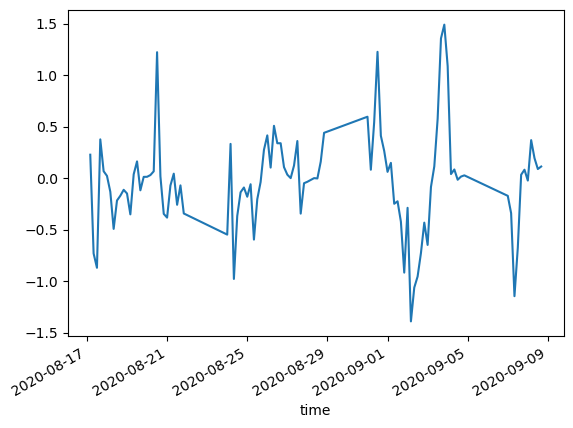

In [51]:
test = (AU_NU['rolling_corr'] - EU_GU['rolling_corr'])
test.iloc[0:100].plot()

## Volatility

In [77]:
import statistics

In [87]:
EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)
EU_GU = EU_GU.dropna()

C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)


In [95]:
EU_GU[['shifted_var', 'diff']]

,shifted_var,diff
time,,
2020-08-25 20:00:00,0.000009,-0.000295
2020-08-26 00:00:00,0.000008,0.000101
2020-08-26 04:00:00,0.000008,-0.000894
2020-08-26 08:00:00,0.000008,-0.001304
2020-08-26 12:00:00,0.000007,-0.000406
...,...,...
2023-10-27 04:00:00,0.000018,0.000023
2023-10-27 08:00:00,0.000018,0.000296
2023-10-27 12:00:00,0.000019,-0.000814


In [94]:
EU_GU[['shifted_var', 'diff']].corr()

,shifted_var,diff
shifted_var,1.000000,-0.008661
diff,-0.008661,1.000000


In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(EU_GU[['shifted_var', 'diff']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1
ssr based chi2 test:   chi2=17.6042 , p=0.0000  , df=1
likelihood ratio test: chi2=17.5730 , p=0.0000  , df=1
parameter F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2
ssr based chi2 test:   chi2=15.2663 , p=0.0005  , df=2
likelihood ratio test: chi2=15.2428 , p=0.0005  , df=2
parameter F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3
ssr based chi2 test:   chi2=22.6318 , p=0.0000  , df=3
likelihood ratio test: chi2=22.5802 , p=0.0000  , df=3
parameter F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9382  , p=0.

{1: ({'ssr_ftest': (17.593569288270537, 2.7829744290187754e-05, 4947.0, 1),
   'ssr_chi2test': (17.60423852373947, 2.719814839331614e-05, 1),
   'lrtest': (17.573008585182833, 2.764849733692958e-05, 1),
   'params_ftest': (17.593569288271233, 2.782974429017248e-05, 4947.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.625430681520601, 0.0004936451352256021, 4944.0, 2),
   'ssr_chi2test': (15.266284968788614, 0.0004841370721632451, 2),
   'lrtest': (15.242787163122557, 0.0004898586971740638, 2),
   'params_ftest': (7.62543068148382, 0.0004936451352438352, 4944.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.533255815021851, 5.010150177554462e-05, 4941.0, 3),
   'ssr_chi2test': (22.63178492576085, 4.8186359035413456e-05, 3),
   'lrtest': (22.580184158694465, 4.939378836333214e-05, 3),
   'params_ftest': (7.533255815021984, 5.010150177553972e-05, 4941.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,